# From Neural Variability to Population Coding

## Import

In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Brain Observatory Setup 
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

## Tuning curve for the drifting grating stimulus

In [3]:
cell_id = 541513979

# get the experiment session where this cell has the drifting grating stimulus
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

# get dff traces
timestamps, dff = data_set.get_dff_traces()
cell_index = data_set.get_cell_specimen_indices([cell_id])[0]
dff_trace = dff[cell_index,:]

2024-06-19 22:14:41,231 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/541045923


In [4]:
# get the stimulus table for the drifting grating stimulus
stim_table = data_set.get_stimulus_table('drifting_gratings')
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


In [5]:
# mean DF/F during the grating presentation
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

In [217]:
# create a pandas DataFrame to hold the response of the neuron in each trial
response = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response['orientation'] = stim_table.orientation
response['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    response.loc[ind, 'trial_response'] = dff_trace[int(row_stim.start):int(row_stim.end)].mean()

Text(0, 0.5, 'Mean DFF (%)')

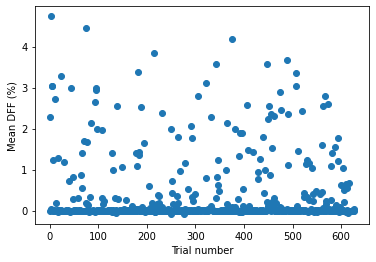

In [218]:
# Plot the trial_response for all trials
plt.plot(response.trial_response, 'o')
plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")

Text(0, 0.5, 'Mean DF/F')

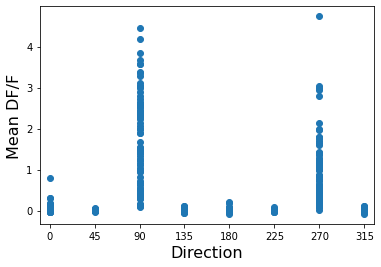

In [219]:
# plot grating response as a function of the grating orientation
plt.plot(response.orientation.values, response.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Text(0, 0.5, 'Mean response (DFF)')

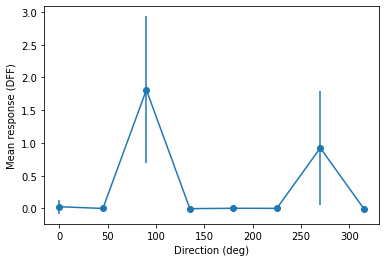

In [220]:
# tuning curve
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

# compute
tuning = np.empty((8))
tuning_std = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = trials.trial_response.mean()
    tuning_std[i] = trials.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

## Can we decode the stimulus orientation on a trial-to-trial basis by looking at the responses of this neuron?

Text(0, 0.5, 'Mean DFF (%)')

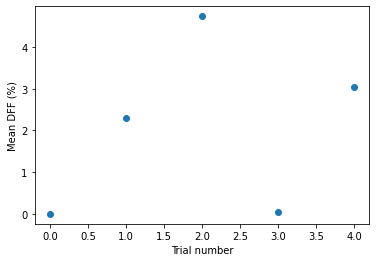

In [17]:
# Plot the trial_response for the first 5 trials
plt.plot(response.trial_response[:5], 'o')
plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")

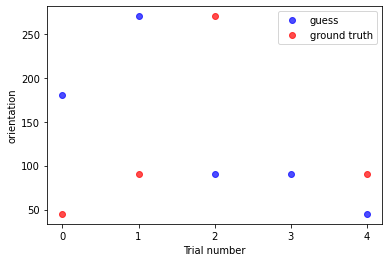

In [237]:
# take a guess for the presented orientation
ori_guess_from_neural_resp = np.array([180, 270, 90, 90, 45])

plt.plot(ori_guess_from_neural_resp, 'o', c='b', label='guess', alpha=0.7)
plt.plot(response.orientation[:5].values, 'o', c='r', label='ground truth', alpha=0.7)
plt.xlabel("Trial number")
plt.xticks(np.arange(5))
plt.ylabel("orientation")
plt.legend()

### Why are our guesses so deviated from the ground truth? What does it tell us about single neural responses and coding?
- variability in neural response
- ambiguity due to selectivity of neural response

### How can we do better at decoding the stimulus orientation from neural responses?

### Let's see what happen when we have access to another neuron

In [25]:
# total number of cells in the session
dff.shape

(290, 115741)

In [368]:
# note the above cell is index 6
# same tuning as 6: 44, 56
dff_trace_neuron2 = dff[51, :]  # current best
# 51: 45, 225
# 69: 0, 180
# dff_trace_neuron2 = dff[75, :]

# create a pandas DataFrame to hold the response of the neuron in each trial
response_neuron2 = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response_neuron2['orientation'] = stim_table.orientation
response_neuron2['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    response_neuron2.loc[ind, 'trial_response'] = dff_trace_neuron2[int(row_stim.start):int(row_stim.end)].mean()


Text(0, 0.5, 'Mean DFF (%)')

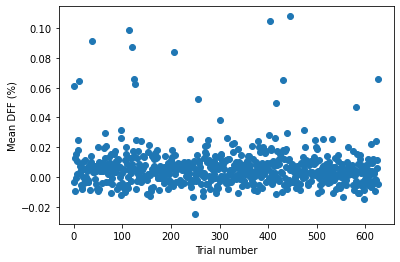

In [369]:
# Plot the trial_response for all trials
plt.plot(response_neuron2.trial_response, 'o')
plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")

Text(0, 0.5, 'Mean DF/F')

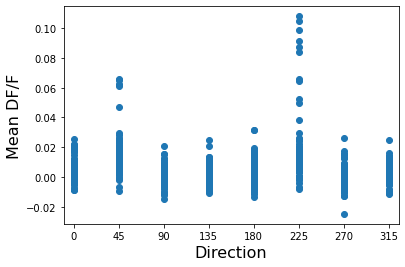

In [370]:
# plot grating response as a function of the grating orientation
plt.plot(response_neuron2.orientation.values, response_neuron2.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Text(0, 0.5, 'Mean response (DFF)')

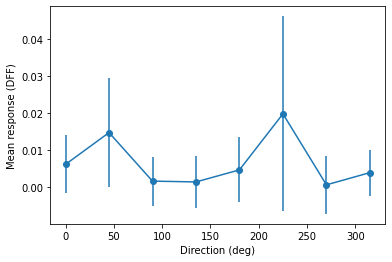

In [371]:
# tuning curve
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

# compute
tuning_neuron2 = np.empty((8))
tuning_std_neuron2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response_neuron2[response.orientation==ori]
    tuning_neuron2[i] = trials.trial_response.mean()
    tuning_std_neuron2[i] = trials.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning_neuron2, yerr=tuning_std_neuron2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

### put the tuning curves side by side

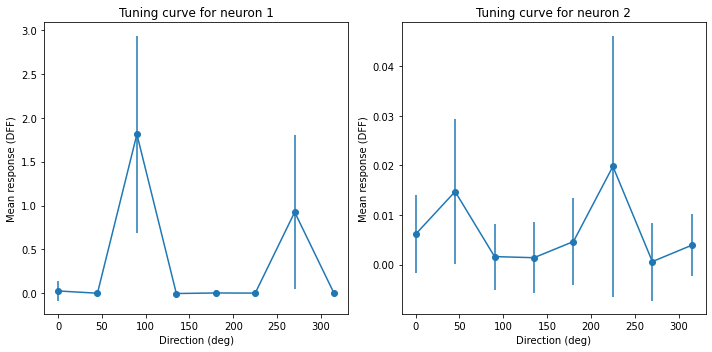

In [228]:
# tuning curve
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.errorbar(orivals, tuning_neuron2, yerr=tuning_std_neuron2, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

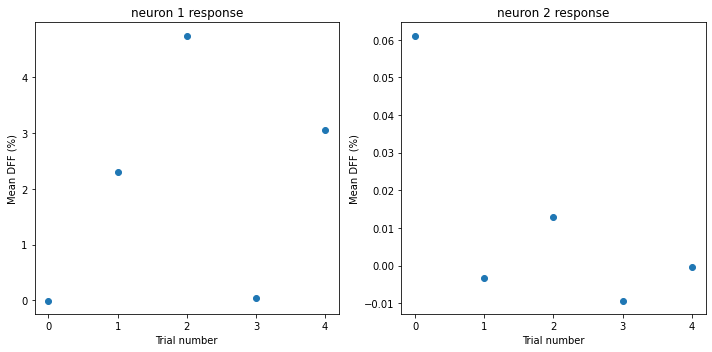

In [230]:
# plot the trial-to-trial response side by side

# Plot the trial_response for the first 5 trials
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('neuron 1 response')
ax.plot(response.trial_response[:5], 'o')
ax.set_xlabel("Trial number")
ax.set_xticks(np.arange(5))
ax.set_ylabel("Mean DFF (%)")

ax = axs[1]
ax.set_title('neuron 2 response')
ax.plot(response_neuron2.trial_response[:5], 'o')
ax.set_xlabel("Trial number")
ax.set_xticks(np.arange(5))
ax.set_ylabel("Mean DFF (%)")

fig.tight_layout()

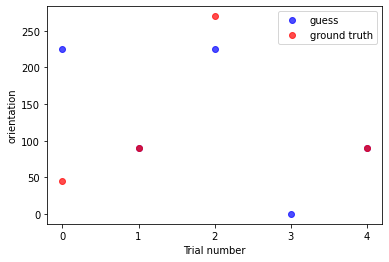

In [236]:
# take a guess for the presented orientation
ori_guess_from_neural_resp = np.array([225, 90, 225, 0, 90])

plt.plot(ori_guess_from_neural_resp, 'o', c='b', label='guess', alpha=0.7)
plt.plot(response.orientation[:5].values, 'o', c='r', label='ground truth', alpha=0.7)
plt.xlabel("Trial number")
plt.xticks(np.arange(5))
plt.ylabel("orientation")
plt.legend()

### What enables us to better decode the simulus orientation when we use two neurons?
- different response selectivity
- more samples trial-to-trial neural response variability

### How can we better visualize the responses of 2 neurons

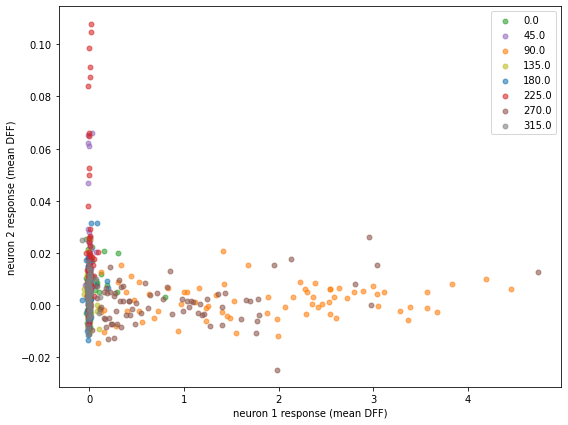

In [393]:
colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:olive',
          'tab:blue', 'tab:red', 'tab:brown', 'tab:gray']

plt.figure(figsize=(9,7))
for i, ori in enumerate(orivals):
    ind = stim_table.orientation[stim_table.orientation==ori].index
    plt.scatter(
        response.trial_response[ind].values, 
        response_neuron2.trial_response[ind].values,
        c=colors[i],
        s=24, alpha=0.6,
        label=f'{ori}'
    )
plt.xlabel('neuron 1 response (mean DFF)')
plt.ylabel('neuron 2 response (mean DFF)')
plt.legend()

### What does the above plot tell us how to decode the stimulus orientation from the responses of 2 neurons?

### What does this imply if we use even more neurons to decode?